# Imports + Colab

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE


In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [4]:
%cd ../../../PyGeM
%ls

/gdrive/My Drive/PyGeM
build/             dist/         LICENSE.rst      readme/    test.py
CITATION.cff       dockerfiles/  pygem/           README.md  tests/
code_formatter.sh  docs/         pygem.egg-info/  setup.py   tutorials/


In [5]:
!python3.10 setup.py install
import pygem

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [6]:
%cd ../Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
%ls

/gdrive/MyDrive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
 controlpoints.png   output/                 testairfoil.geo
 gmshcommands.txt   'Progetto Napde.ipynb'   testairfoil.msh


## Imports

In [7]:
from firedrake import *
import matplotlib.pyplot as plt
from pygem import FFD, RBF
import numpy as np

# Import the mesh

In [42]:
M = Mesh('testairfoil.msh')

# Plot the mesh

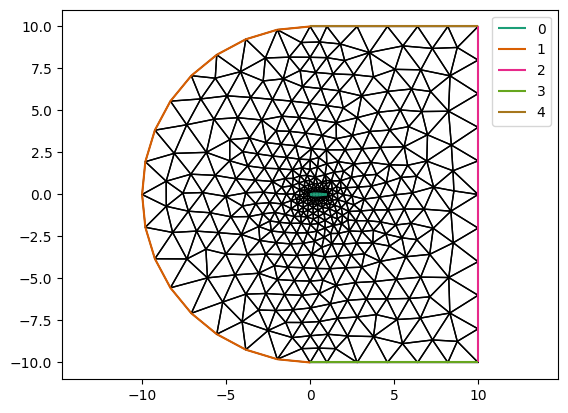

In [9]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.legend()

(-0.35, 0.35)

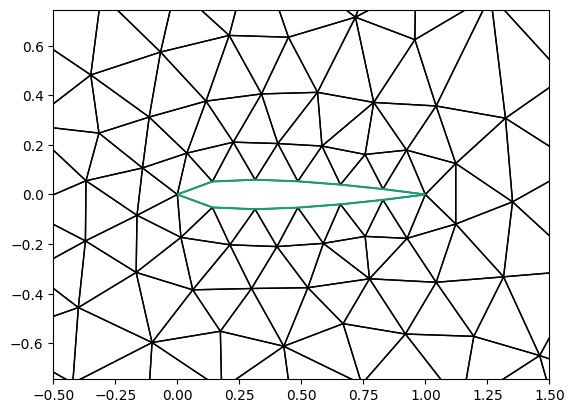

In [10]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Solve stokes to obtain a starting point

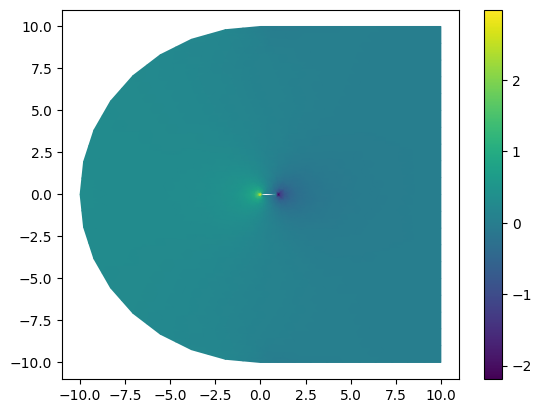

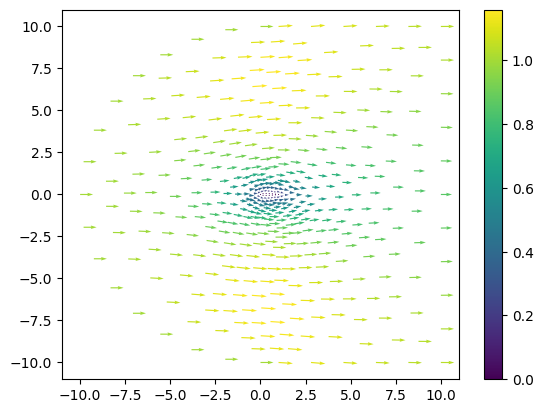

In [49]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

# Set Reynolds Number


In [207]:
Re = Constant(7000)

# Solve Navier Stokes with the initial guess

In [ ]:
# Adimensionalized formulation for high Re
def functional_high_Re(uh, v, ph, q, Re, f):
    G = inner(dot(grad(uh), uh), v) * dx  \
        +  1/Re * inner(grad(uh), grad(v)) * dx  \
        - div(v) * ph * dx  \
        + q * div(uh) * dx \
        - inner(f, v) * dx
    return G

# Adimensionalized formulation for low Re
def functional_low_Re(uh, v, ph, q, Re, f):
    G = Re * inner(dot(grad(uh), uh), v) * dx  \
        +  inner(grad(uh), grad(v)) * dx  \
        - div(v) * ph * dx  \
        + q * div(uh) * dx \
        - inner(f, v) * dx
    return G

In [ ]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary

bcs = (bc1, bc2)

In [ ]:
# Trial and test functions
wh = Function(W)
uh, ph = split(wh) # trial functions
v, q = TestFunctions(W) # test functions
#w=Function(W)
#v, q=split(w)

# Setting the problem
G = functional_high_Re(uh, v, ph, q, Re, f)


In [ ]:
wh.assign(w_stokes)
param = {'ksp_type':'gmres',
         'ksp_pc_type':'mumps',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }
nsp = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])

solve(G == 0, wh, bcs=bcs, solver_parameters=param)

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


## Plotting the solution

In [ ]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)


/usr/local/lib/python3.10/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

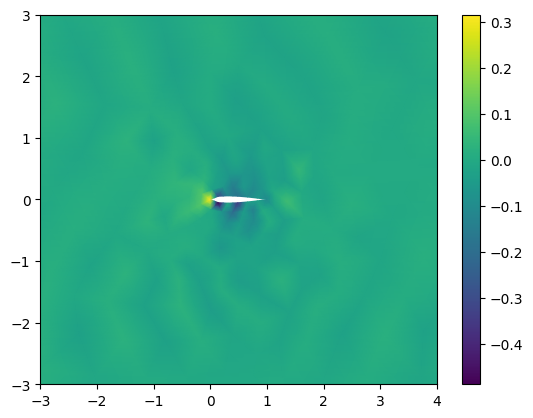

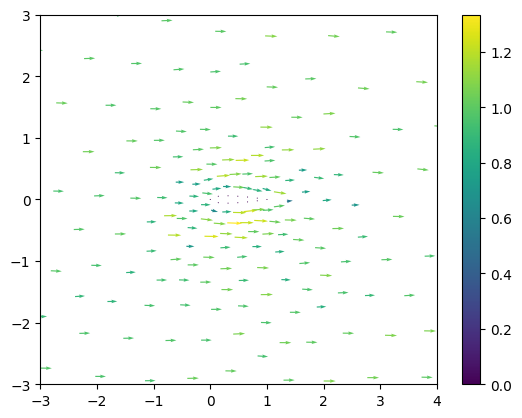

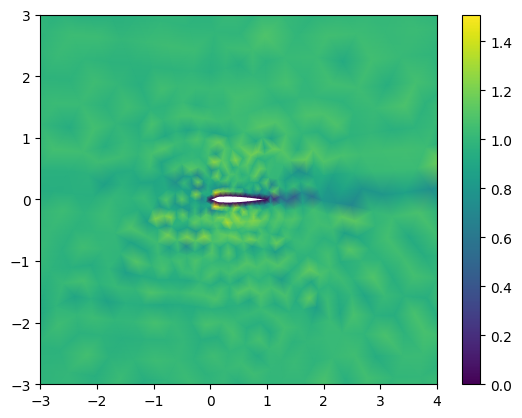

In [ ]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

# Solve Navier Stokes with SUPG Stabilization

In [208]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta=Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [209]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary
bc3 = DirichletBC(W.sub(1), 0, 0) # Dirichlet unitary B.C. on the inflow boundary
bcs = (bc1, bc2)

In [210]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)

while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb, solver_parameters=param)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

19


## Plotting the solution

In [211]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/usr/local/lib/python3.10/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

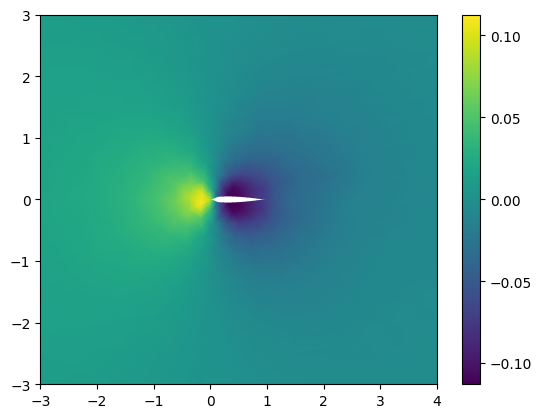

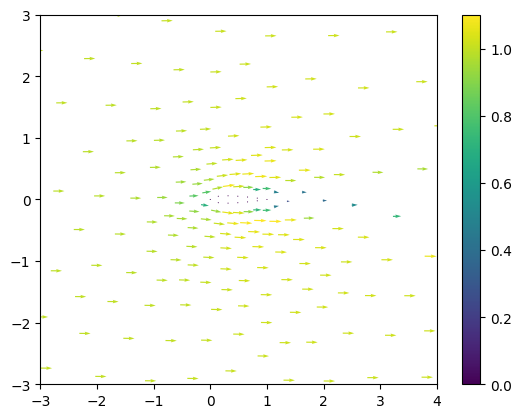

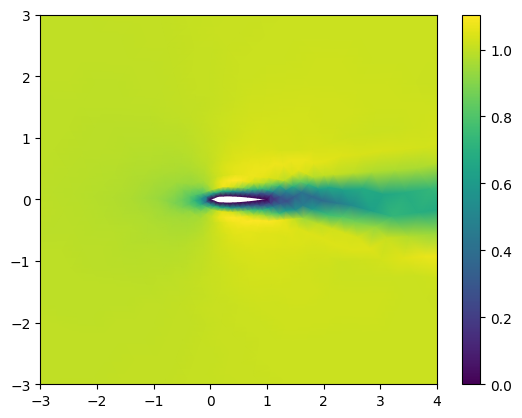

In [212]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

# Computing lift and drag coefficients

In [214]:
obstacle_dofs=bc3.nodes
p=ph.dat.data[obstacle_dofs]

x=M.coordinates.dat.data[obstacle_dofs][:,0]
y=M.coordinates.dat.data[obstacle_dofs][:,1]

Cd=sum(-(p[1:]+p[:-1])*0.5*(y[1:]-y[:-1]))
Cl=sum(-(p[1:]+p[:-1])*0.5*(-x[1:]+x[:-1]))
print(Cd)
print(Cl)
Cd=0
Cl=0

#for i in range(len(p)-1):
#  dist=((y[i+1]-y[i])**2+(x[i+1]-x[i])**2)**0.5
#  Cd+=-(p[i]+p[i+1])*0.5*(y[i+1]-y[i])
#  Cl+=-(p[i]+p[i+1])*0.5*(-x[i+1]+x[i])
#print(Cd)
#print(Cl)

0.007510946056127717
-0.07034306386956868


# Mesh deformation

## Node Extraction

In [100]:
coord=M.coordinates.dat.data
coord.shape

(417, 2)

In [101]:
#extend coord to make it work with FFD
coord = np.c_[coord,np.ones(coord.shape[0])]

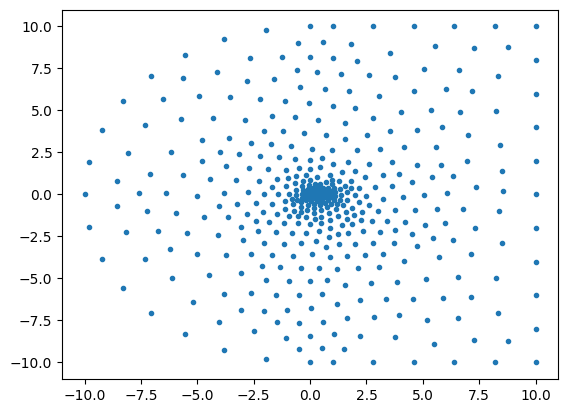

In [102]:
plt.plot(coord[:,0], coord[:,1], '.')

In [103]:
X = VectorFunctionSpace(M, 'P', 1)

b1 = DirichletBC(X, Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
b2 = DirichletBC(X, Constant((0.,0.)), [1, 2, 3, 4]) # Dirichlet unitary B.C. on the inflow boundary


(-0.049999999999999996, 1.05, -0.06536877039857825, 0.06536877039176694)

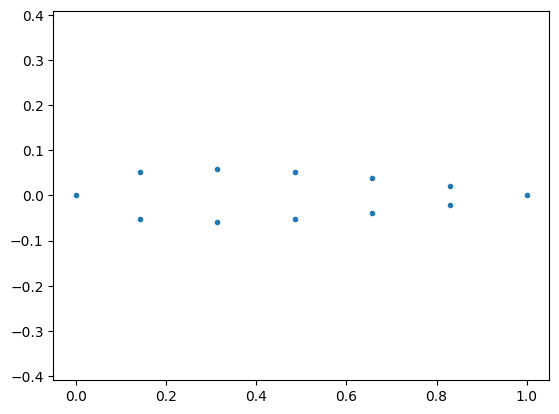

In [104]:
#extract obstacle points
obstacle=coord[b1.nodes, :]
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

(-11.0, 11.0, -11.0, 11.0)

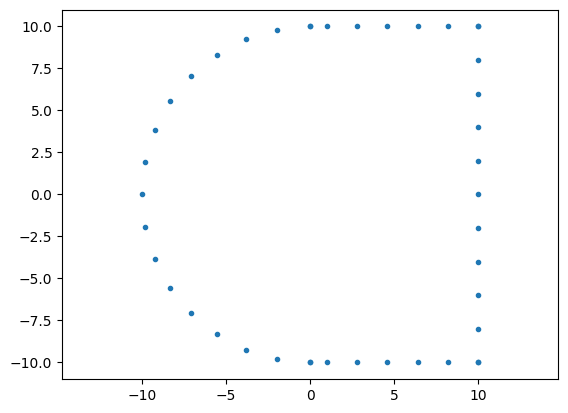

In [105]:
ext_boundary=coord[b2.nodes, :]
plt.plot(ext_boundary[:,0], ext_boundary[:,1], '.')
plt.axis('equal')


## Airfoil deformation

In [20]:
ffd = FFD([3, 3, 1]) #initialize free-form deformation object with the dimensions of the matrix of control points

#define bounding box in which object to deform is contained (position of control points)

ffd.box_origin = np.array([0,-0.5,0.9])
ffd.box_length = np.array([1,1,1.1])


(-0.050000000000000044, 1.05, -0.55, 0.55)

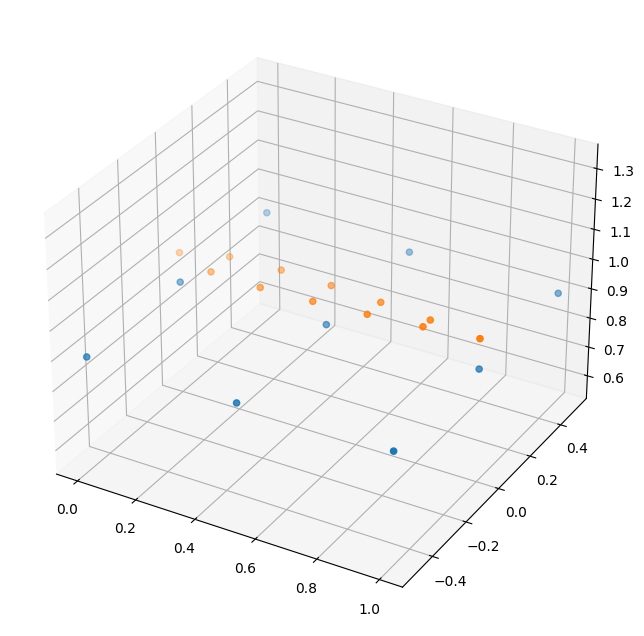

In [21]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(*ffd.control_points().T)
ax.scatter(obstacle[:,0],obstacle[:,1],obstacle[:,2])
ax.axis('equal')

In [22]:
#define movement in each direction for each control point

#ffd.array_mu_x[2, 2, 0] = 0.5
ffd.array_mu_y[2, 1, 0] = 0.5
#ffd.array_mu_z[1, 1, 0] = 0.

(-0.049999999999999996, 1.05, -0.07489746265351345, 0.2654713077454062)

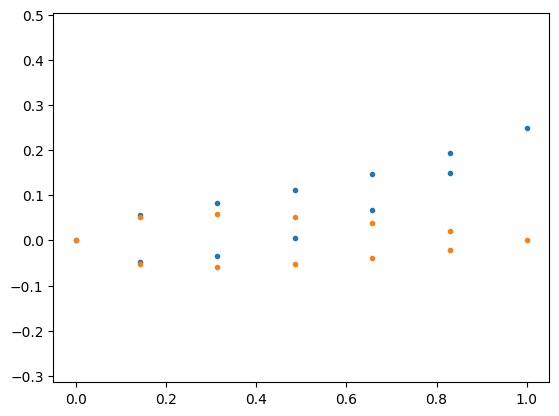

In [23]:
new_obstacle = ffd(obstacle)
plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [24]:
undeformed_points_full = np.vstack([ext_boundary, obstacle])
deformed_points_full= np.vstack([ext_boundary, new_obstacle])

undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
deformed_points   = deformed_points_full[uindexes]

rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points, func='gaussian_spline', radius=1.0)

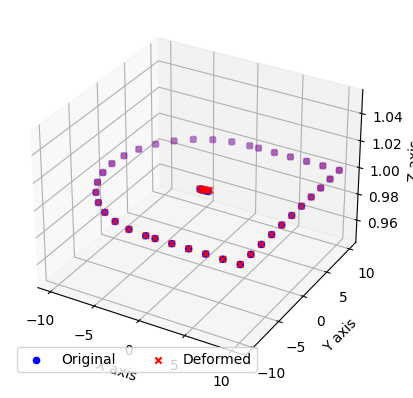

In [25]:
rbf.plot_points(filename="controlpoints")

In [26]:
#propagate deformation to the whole mesh
new_coord=rbf(coord)

(-11.0, 11.0, -11.016796875, 11.008984375)

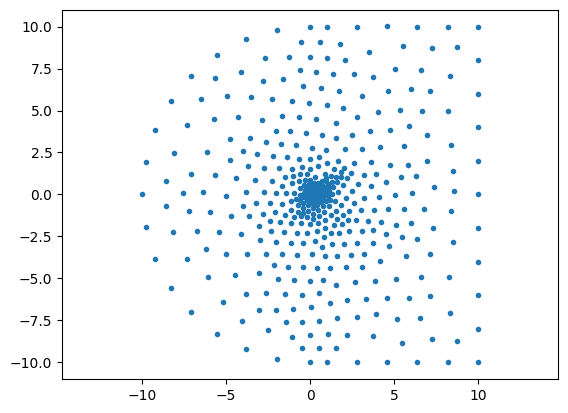

In [27]:
plt.plot(new_coord[:,0], new_coord[:,1], '.')
plt.axis('equal')

In [32]:
new_coords_func = Function(M.coordinates.function_space())
new_coords_func.dat.data[:] = new_coord[:,:2]
initial_mesh.coordinates.assign(new_coords_func)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f22dffe33a0>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 1)

(-0.35, 0.35)

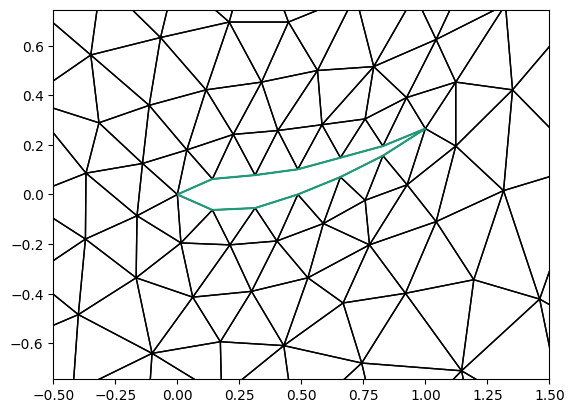

In [34]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)